In [3]:
#Data handling
import h5py

import logging
#Mathematical libraries
import numpy as np

import pandas as pd

%matplotlib inline

import bottleneck

import matplotlib.pyplot as plt

In [216]:
df_go_id_enseml = pd.read_csv('/data/lohia/gene_distance_expresseion/ENST_ENSG_mapping_v2.txt', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
df_go_id_enseml.dropna(subset=['Gene stable ID'])
mydict_EID_UID = dict(zip(df_go_id_enseml['Gene stable ID'], df_go_id_enseml['Transcript stable ID']))

In [268]:
df_ncbi_gene_type_enseml = pd.read_csv('/data/lohia/gene_distance_expresseion/ENST_ENSG_NCBI_gene_type.txt', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
mydict_EID_NID = dict(zip(df_ncbi_gene_type_enseml['Gene stable ID'], df_ncbi_gene_type_enseml['NCBI gene (formerly Entrezgene) ID']))
mydict_EID_genetype = dict(zip(df_ncbi_gene_type_enseml['Gene stable ID'], df_ncbi_gene_type_enseml['Gene type']))

In [349]:
df_ncbi_gene_type_enseml[df_ncbi_gene_type_enseml['Gene stable ID'] == 'ENSG00000210049']

Gene stable ID Transcript stable ID Gene type  \
0  ENSG00000210049      ENST00000387314   Mt_tRNA   

   NCBI gene (formerly Entrezgene) ID  
0                                 NaN

In [265]:
df_ncbi_gene_type_enseml

Gene stable ID Transcript stable ID             Gene type  \
0       ENSG00000210049      ENST00000387314               Mt_tRNA   
1       ENSG00000211459      ENST00000389680               Mt_rRNA   
2       ENSG00000210077      ENST00000387342               Mt_tRNA   
3       ENSG00000210082      ENST00000387347               Mt_rRNA   
4       ENSG00000209082      ENST00000386347               Mt_tRNA   
...                 ...                  ...                   ...   
254182  ENSG00000285363      ENST00000642800  processed_pseudogene   
254183  ENSG00000285114      ENST00000645112        protein_coding   
254184  ENSG00000285114      ENST00000642712        protein_coding   
254185  ENSG00000285114      ENST00000646090        protein_coding   
254186  ENSG00000285114      ENST00000643960        protein_coding   

        NCBI gene (formerly Entrezgene) ID  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
...                                    ...  
254182                                 NaN  
254183                             56169.0  
254184                             56169.0  
254185                             56169.0  
254186                             56169.0  

[254187 rows x 4 columns]

In [218]:
from scipy.sparse import coo_matrix
#df_go_id_enseml = pd.read_csv('/data/johlee/geneIDConversions/9606_gene_info.tab', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
#df_go_id_enseml.dropna(subset=['EnsemblID'])
#mydict_EID_UID = dict(zip(df_go_id_enseml.EnsemblID, df_go_id_enseml.UniProtID))
def parse_go_hd5(filename, mydict_EID_UID=mydict_EID_UID):
    """
    Loads data in file to dataframe.
    """
    with h5py.File(filename, 'r') as f:
        col_uid = []
        logging.debug("reading matrix...")
        row = [ s.decode() for s in  f['GO'][:] ]
        columns = [ s.decode() for s in  f['genes'][:] ]
        matrix = f['ind'][:] - 1 #the indices in this matrix are stored from 1 
        coo = coo_matrix(( np.ones(1901323) , (matrix[0,:],matrix[1,:] )), shape=(len(columns), len(row)) )
        logging.debug("reading columns. converting to unicode")
        for x in columns:
            try:
                v = mydict_EID_UID[x]
                col_uid.append(x)
            except KeyError:
                print (x)
                col_uid.append('del')
        #col_uid = [mydict_EID_UID[x] for x in columns]
        logging.debug("making dataframe...")

        print (coo.toarray().shape)
        df = pd.DataFrame(coo.toarray(),  index=col_uid, columns = row )
    return df



In [5]:
def parse_expression_hd5_lee(filename, mydict_EID_UID=mydict_EID_UID):
    """
    Loads data in file to dataframe.
    """
    col_uid = []
    row_uid = []
    with h5py.File(filename, 'r') as f:
        logging.debug("reading matrix...")
        matrix = f['agg'][:]
        logging.debug("reading rows. converting to unicode.")
        rows = [ s.decode() for s in  f['row'][:] ]
        counter = 0
        for x in rows:
            try:
                x_o = x.split(".")[0]
                v = mydict_EID_UID[x_o]
                row_uid.append(x_o)
                #print (x)
            except KeyError:
 
                counter = counter + 1
                row_uid.append('del')
                #print (x)
        print (counter)
        logging.debug("reading columns. converting to unicode")
        columns = [ s.decode() for s in  f['col'][:] ]
        for x in columns:
            try:
                x_o = x.split(".")[0]
                v = mydict_EID_UID[x_o]
                col_uid.append(x_o)
            except KeyError:
                col_uid.append('del')
                #print (x)
        logging.debug("making dataframe...")
        df = pd.DataFrame(matrix,  index=row_uid, columns = col_uid)
    return df 

In [6]:
import bottleneck
import scipy.stats as stats
def prec_recall (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial = df_trial.reset_index()
    #df_trial['true_neg'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    #df_trial['true_pos'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg'].cumsum()
    df_trial['PPV'] = df_trial['true_pos_cum'] / (df_trial['true_pos_cum'] + df_trial['true_neg_cum'] )
    df_trial['recall'] = df_trial['true_pos_cum']  / (df_trial['true_pos'].sum())
    #df_trial['recall'] = df_trial['recall'].round(1)
    #df_trial['f-score'] = (2 * df_trial['PPV'] * df_trial['recall']) / (df_trial['PPV'] + df_trial['recall'])
    #df_trial.iloc[df_trial['f-score'].idxmax()]
    return list(zip(df_trial['recall'].tolist(), df_trial['PPV'].tolist()))



def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
        
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()
    
def calc_auc_curve (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial['true_neg_tmp'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    df_trial['true_pos_tmp'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos_tmp'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg_tmp'].cumsum()
    #return dict(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))
    #df_trial['true_neg_cum'] = df_trial['true_neg_cum'].round(1)
    return list(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))

In [7]:
exp_lee = parse_expression_hd5_lee("/data/johlee/CoCoCoNet/networks/human_prioAggNet.hdf5")
go_df = parse_go_hd5("/data/johlee/CoCoCoNet/gene2go/human_gene2go.hdf5")

135


In [8]:
duplicates = exp_lee.index.duplicated(keep='first')
exp_lee = exp_lee.loc[~duplicates, ~duplicates]

duplicates = go_df.index.duplicated(keep='first')
go_df = go_df.loc[~duplicates, ~duplicates]

In [9]:
exp_lee.drop(['del'], inplace=True)
del exp_lee['del']

go_df.drop(['del'], inplace=True)
del go_df['del']


In [ ]:
df_raw_files = pd.read_csv('/data/lohia/gene_distance_expresseion/dist_files/%s/chr%s_%s.csv' %(dist_type, chrm, dist_type)) data/gene_distance_expresseion/gene_files

(7906, 7908)
(7842, 7842)
(4011, 4011)
(7906, 7908)
(7842, 7842)
(4011, 4011)
(7906, 7908)
(7842, 7842)
(4011, 4011)
(7906, 7908)
(7842, 7842)
(4011, 4011)
(5778, 5780)
(5723, 5723)
(2913, 2913)
(5778, 5780)
(5723, 5723)
(2913, 2913)
(5778, 5780)
(5723, 5723)
(2913, 2913)
(5778, 5780)
(5723, 5723)
(2913, 2913)
(4799, 4801)
(4737, 4737)
(2246, 2246)
(4799, 4801)
(4737, 4737)
(2246, 2246)
(4799, 4801)
(4737, 4737)
(2246, 2246)
(4799, 4801)
(4737, 4737)
(2246, 2246)
(3467, 3469)
(3411, 3411)
(1745, 1745)
(3467, 3469)
(3411, 3411)
(1745, 1745)
(3467, 3469)
(3411, 3411)
(1745, 1745)
(3467, 3469)
(3411, 3411)
(1745, 1745)
(4041, 4043)
(4003, 4003)
(2137, 2137)
(4041, 4043)
(4003, 4003)
(2137, 2137)
(4041, 4043)
(4003, 4003)
(2137, 2137)
(4041, 4043)
(4003, 4003)
(2137, 2137)
(4154, 4156)
(4101, 4101)
(2067, 2067)
(4154, 4156)
(4101, 4101)
(2067, 2067)
(4154, 4156)
(4101, 4101)
(2067, 2067)
(4154, 4156)
(4101, 4101)
(2067, 2067)
(3969, 3971)
(3921, 3921)
(1990, 1990)
(3969, 3971)
(3921, 3921)

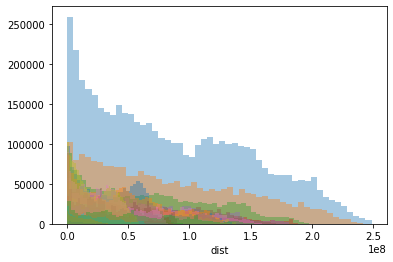

In [335]:
matrix_all_dist = []
chr_list = list(range(1,23)) + ['X', 'Y']
#chr_list = list(range(1,2))
df_go_id_enseml = pd.read_csv('/data/lohia/gene_distance_expresseion/ENST_ENSG_mapping_v2.txt', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
df_go_id_enseml.dropna(subset=['Gene stable ID'])
mydict_EID_UID = dict(zip(df_go_id_enseml['Transcript stable ID'], df_go_id_enseml['Gene stable ID']))
for chrm in chr_list:
    d_l = []
    
    for dist_type in ['tes_tes', 'tes_tss', 'tss_tes', 'tss_tss']:
        df_ensg_matrix = pd.read_csv('/data/lohia/gene_distance_expresseion/dist_files/%s/chr%s_%s.csv' %(dist_type, chrm, dist_type)) 
        df_ensg_matrix['ensg'] = [mydict_EID_UID[x.split(".")[0]] if x.split(".")[0] in df_go_id_enseml['Transcript stable ID'].to_list() else 'del' for x in df_ensg_matrix['Unnamed: 0'] ]
        print (df_ensg_matrix.shape)
        df_ensg_matrix.set_index('ensg', inplace = True)

        del df_ensg_matrix['Unnamed: 0']

        y = [mydict_EID_UID[x.split(".")[0]] if x.split(".")[0] in df_go_id_enseml['Transcript stable ID'].to_list() else 'del' for x in df_ensg_matrix.columns ]

        df_ensg_matrix.columns = y

        df_ensg_matrix.drop(['del'], inplace=True)

        del df_ensg_matrix['del']
        print (df_ensg_matrix.shape)

        duplicates = df_ensg_matrix.index.duplicated(keep='first')
        df_ensg_matrix = df_ensg_matrix.loc[~duplicates, ~duplicates]
        print (df_ensg_matrix.shape)

        subset_cols = list (set(exp_lee.index) & set(df_ensg_matrix.index))
        

        exp_subset = exp_lee.loc[subset_cols, subset_cols]
        df_ensg_subset = df_ensg_matrix.loc[subset_cols, subset_cols]

        long_form = df_ensg_subset.unstack()

        long_form.index.rename(['col_1', 'col_2'], inplace=True)

        long_form = long_form.to_frame(dist_type).reset_index()
        d_l.append(long_form[dist_type])

        df = long_form

    long_form = exp_subset.unstack()
    long_form = long_form.to_frame('exp').reset_index()

    

    df['exp'] = long_form['exp']
    for i,d  in zip(['tes_tes', 'tes_tss', 'tss_tes'], d_l):
        df[i] = d
    df['dist'] = df[['tes_tes', 'tes_tss', 'tss_tes', 'tss_tss']].min(axis=1)
    import seaborn as sns
    sns.distplot(df['dist'], hist=True, kde=False)
    matrix_all_dist.append((chrm, len(subset_cols), df))

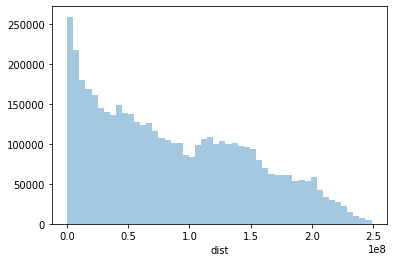

In [168]:
for chrm, num_pairs, df in matrix_all_dist[0:1]:
    df['dist'] = df[['tes_tes', 'tes_tss', 'tss_tes', 'tss_tss']].min(axis=1)
    import seaborn as sns
    sns.distplot(df['dist'], hist=True, kde=False)

In [336]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
m_l = []
for chrm, num_pairs, df in matrix_all_dist:
    prot_list_sp = np.array_split(df, num_pairs, axis=0)
    for i in range(0,num_pairs):

        long_form_top = prot_list_sp[int(i)]
        long_form_top['dist'] = long_form_top[['tes_tes', 'tes_tss', 'tss_tes', 'tss_tss']].min(axis=1)
        #long_form_top['dist'] = long_form_top['tes_tes']
        #long_form_top = long_form_top[long_form_top["tm_score"] >= 0.0]
        #long_form_top = long_form_top[long_form_top["tm_score"] < 1]

        #print (long_form_top)
        long_form_top = long_form_top[long_form_top['col_1'] != long_form_top['col_2']]
        #long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
#        try: 
#           mp =  long_form_top['col_1'].values[0]
#           top_match_protein = long_form_top['col_2'].values[0]
#           dom_pair_a = long_form_top['max_dom_pair'].values[0][0] #this gets the domain pair with the highest matching 
#           dom_pair_b = long_form_top['max_dom_pair'].values[0][1]
#           real_tm_score = long_form_top["tm_score"].values[0]
#           para_dig =  long_form_top["paralogues_dig"].values[0]
#        except IndexError:
#           mp = ''
#           top_match_protein = ''
        #print (long_form_top['col_1'].values[0])
        #long_form_top = long_form_top[long_form_top["tm_score"] <= 0.98]
        #long_form_top = long_form_top[long_form_top["exp"] >= 0.6]
        
        exp_median = long_form_top['exp'].median()
        exp_mean = long_form_top['exp'].mean()
        exp_var = long_form_top['exp'].var()
        if exp_median >= 0.00:
            #long_form_top = long_form_top[~((long_form_top["exp"] > 0.2) & (long_form_top["exp"] < 0.8)) ]
            
            #long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)  
            #long_form_top = long_form_top.head(10)
            

            #long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
            long_form_top = long_form_top.reset_index()
            long_form_top["True_sim"] = long_form_top["dist"] * 0
            

            
            try: 
                
                tmp_df = long_form_top[long_form_top.dist == long_form_top.dist.min()].sample()
                #print (long_form_top.head())
                #print (tmp_df)
                #print (tmp_df.index.values[0])
                #print ("--------")
                
                
                #long_form_top.at[tmp_df.index.values[0], 'True_sim'] = 1
                long_form_top.at[tmp_df.index.values[0], 'True_sim'] = 1
                
                
                mp =  long_form_top.loc[ tmp_df.index.values[0] , : ]['col_1']

                top_match_protein = long_form_top.loc[ tmp_df.index.values[0] , : ]['col_2']
                #dom_pair_a = long_form_top.loc[ tmp_df.index.values[0] , : ]['max_dom_pair'][0] #this gets the domain pair with the highest matching 
                #dom_pair_b = long_form_top.loc[ tmp_df.index.values[0] , : ]['max_dom_pair'][1]
                real_tm_score = long_form_top.loc[ tmp_df.index.values[0] , : ]["dist"]
                #para_dig =  long_form_top.loc[ tmp_df.index.values[0] , : ]["paralogues_dig"]
            except TypeError:
                mp = ''
                top_match_protein = ''
            #print ("here")
            #
            
            #rank(long_form_top["tm_score"].to_numpy())
            #rank(long_form_top['exp'].to_numpy())
            dist_thresh = 0
            for dist_thresh in [0]:
                #long_form_top["True_sim"] = [1 if score <= dist_thresh else 0 for score in long_form_top["dist"]]
                
                #long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)  
                #long_form_top['true_pos_cum'] = long_form_top['True_sim'].cumsum()
                #long_form_top = long_form_top[long_form_top['true_pos_cum'] <=2]
                
                #long_form_top["True_sim"] = long_form_top["tm_score"] * 0
                #long_form_top["True_sim"][0:1] = long_form_top["True_sim"][0:1] + 1 
                
                #long_form_top["True_sim"] = long_form_top["paralogues_dig"] 
                #long_form_top["True_sim"][0:1] = long_form_top["True_sim"][0:1] + 1 
                
                
                #long_form_top["True_sim"][0:9] = (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
                #print (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
                #print (long_form_top["True_sim"])
                #the top ten macthes are considered TP
                #print (long_form_top)
                #rank_abs = lambda x: stats.rankdata(np.abs(x))
                #predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[long_form_top].values)
                
                long_form_top["true_pos"] = [score for score in long_form_top["True_sim"]]
                long_form_top["true_neg"] = [1 if score==0 else 0 for score in long_form_top["True_sim"]]
                #print (long_form_top["true_pos"].sum())
                #print (long_form_top["true_neg"].sum())
                long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp"]]
                #print ("here2")
                
                ca = calc_auroc (long_form_top,predicted_score='predicted_sim_from_exp')
                m_curve = calc_auc_curve (long_form_top,predicted_score='predicted_sim_from_exp')
                pr_curve = prec_recall (long_form_top,predicted_score='predicted_sim_from_exp')

                tpd = pd.DataFrame(m_curve)
                if m_curve:
                    tpd[0] =  tpd[0].astype(float).round(2)
                    tpd = tpd.groupby([0]).mean()
                    #print (tpd)
                    #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                    m_curve  = dict(zip(tpd.index, tpd[1]))
                   #print (m_curve)
                else:
                    m_curve  = {}
                tpd = pd.DataFrame(pr_curve)
                #print (pr_curve)
                if pr_curve:
                    tpd[0] =  tpd[0].astype(float).round(2)
                    tpd = tpd.groupby([0]).mean()
                    #print (tpd)
                    #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                    pr_curve  = dict(zip(tpd.index, tpd[1]))
                else:
                    pr_curve  = {}
                m_l.append((chrm, num_pairs,dist_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp, exp_median, exp_mean, exp_var, top_match_protein, real_tm_score))
                
            #m_l.append((sim_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp, exp_median, exp_mean, exp_var, top_match_protein, dom_pair_a, dom_pair_b, real_tm_score, para_dig))
        else:
            pass

In [337]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'num_pairs','dist_thresh',  'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name', 'exp_median', 'exp_mean', 'exp_var', 'top_match_protein', 'real_tm_score'])

In [338]:
df_scores.dropna(inplace=True)

In [339]:
df_scores['gene_type'] = [mydict_EID_genetype[x] for x in df_scores['prot_name'] ]

In [340]:
df_scores['nid'] = [mydict_EID_NID[x] for x in df_scores['prot_name'] ]

In [341]:
df_scores = df_scores.loc[df_scores['gene_type'] != 'protein_coding']

In [342]:
df_scores

threshold  num_pairs  dist_thresh       auc  \
6             1       2171            0  0.056247   
9             1       2171            0  0.872291   
16            1       2171            0  0.855233   
28            1       2171            0  0.993545   
35            1       2171            0  1.000000   
...         ...        ...          ...       ...   
21503         Y         17            0  0.266667   
21504         Y         17            0  0.600000   
21509         Y         17            0  0.800000   
21510         Y         17            0  1.000000   
21514         Y         17            0  0.600000   

                                                    plot  \
6      {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
9      {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
16     {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
28     {0.0: 0.0, 0.01: 0.8260869565217391, 0.02: 1.0...   
35     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
...                                                  ...   
21503  {0.07: 0.0, 0.13: 0.0, 0.2: 0.0, 0.27: 0.0, 0....   
21504  {0.07: 0.0, 0.13: 0.0, 0.2: 0.0, 0.27: 0.0, 0....   
21509  {0.07: 0.0, 0.13: 0.0, 0.2: 0.5, 0.27: 1.0, 0....   
21510  {0.0: 1.0, 0.07: 1.0, 0.13: 1.0, 0.2: 1.0, 0.2...   
21514  {0.07: 0.0, 0.13: 0.0, 0.2: 0.0, 0.27: 0.0, 0....   

                                     pr_curve  true_pos  true_neg  \
6      {0.0: 0.0, 1.0: 0.0004742928286006529}         1      2169   
9      {0.0: 0.0, 1.0: 0.0010865775854818705}         1      2169   
16     {0.0: 0.0, 1.0: 0.0010408019106610958}         1      2169   
28     {0.0: 0.0, 1.0: 0.0023229898802983664}         1      2169   
35                {1.0: 0.003806418667504885}         1      2169   
...                                       ...       ...       ...   
21503    {0.0: 0.0, 1.0: 0.07217032967032967}         1        15   
21504    {0.0: 0.0, 1.0: 0.09307289932289933}         1        15   
21509    {0.0: 0.0, 1.0: 0.11903043537658921}         1        15   
21510               {1.0: 0.2112955620768121}         1        15   
21514    {0.0: 0.0, 1.0: 0.09307289932289933}         1        15   

             prot_name  exp_median  exp_mean   exp_var top_match_protein  \
6      ENSG00000233396    0.572579  0.539141  0.052416   ENSG00000201558   
9      ENSG00000225767    0.317503  0.342324  0.049811   ENSG00000185104   
16     ENSG00000223263    0.362719  0.362979  0.040331   ENSG00000142864   
28     ENSG00000283317    0.487097  0.457156  0.036492   ENSG00000283696   
35     ENSG00000284735    0.361791  0.366787  0.036298   ENSG00000284642   
...                ...         ...       ...       ...               ...   
21503  ENSG00000273906    0.746071  0.720279  0.004002   ENSG00000092377   
21504  ENSG00000176728    0.963155  0.918412  0.010532   ENSG00000260197   
21509  ENSG00000231535    0.916279  0.867249  0.014621   ENSG00000067646   
21510  ENSG00000260197    0.962056  0.916363  0.009947   ENSG00000012817   
21514  ENSG00000229236    0.951848  0.904302  0.012326   ENSG00000198692   

       real_tm_score gene_type          nid  
6                358    lncRNA          NaN  
9              24441    lncRNA          NaN  
16              9404     snRNA          NaN  
28             11019    lncRNA          NaN  
35             12512    lncRNA          NaN  
...              ...       ...          ...  
21503           7996    lncRNA          NaN  
21504         813712    lncRNA      83869.0  
21509          20405    lncRNA  100873962.0  
21510          10808    lncRNA          NaN  
21514          56496    lncRNA     246119.0  

[5479 rows x 16 columns]

In [343]:
df_scores.to_csv('/data/lohia/gene_distance_expresseion/chr_all_auc.csv',index=False) 

In [327]:
pd.crosstab(df_scores.gene_type != 'protein_coding', df_scores.auc > 0.99)

auc        False  True 
gene_type              
False       1363    324
True         272    212

In [306]:
from scipy.stats import fisher_exact
tab = pd.crosstab( df_scores.gene_type == 'protein_coding', df_scores.auc > 0.9)
fisher_exact(tab)

(0.33023165018219675, 5.165492880026167e-25)

In [291]:
df_scores[df_scores[0.00]>.99]

threshold  num_pairs  dist_thresh  auc                     pr_curve  \
35            1       2171            0  1.0  {1.0: 0.003806418667504885}   
102           1       2171            0  1.0  {1.0: 0.003806418667504885}   
122           1       2171            0  1.0  {1.0: 0.003806418667504885}   
153           1       2171            0  1.0  {1.0: 0.003806418667504885}   
170           1       2171            0  1.0  {1.0: 0.003806418667504885}   
...         ...        ...          ...  ...                          ...   
2115          1       2171            0  1.0  {1.0: 0.003806418667504885}   
2119          1       2171            0  1.0  {1.0: 0.003806418667504885}   
2120          1       2171            0  1.0  {1.0: 0.003806418667504885}   
2122          1       2171            0  1.0  {1.0: 0.003806418667504885}   
2133          1       2171            0  1.0  {1.0: 0.003806418667504885}   

      true_pos  true_neg        prot_name  exp_median  exp_mean  ...  0.91  \
35           1      2169  ENSG00000284735    0.361791  0.366787  ...   1.0   
102          1      2169  ENSG00000260920    0.724686  0.665667  ...   1.0   
122          1      2169  ENSG00000226419    0.543566  0.511762  ...   1.0   
153          1      2169  ENSG00000231691    0.157885  0.170043  ...   1.0   
170          1      2169  ENSG00000175147    0.435841  0.418541  ...   1.0   
...        ...       ...              ...         ...       ...  ...   ...   
2115         1      2169  ENSG00000238279    0.555043  0.509619  ...   1.0   
2119         1      2169  ENSG00000237424    0.621938  0.563109  ...   1.0   
2120         1      2169  ENSG00000228548    0.185501  0.212215  ...   1.0   
2122         1      2169  ENSG00000231407    0.527322  0.510189  ...   1.0   
2133         1      2169  ENSG00000232912    0.526828  0.499862  ...   1.0   

     0.92  0.93 0.94  0.95  0.96  0.97  0.98  0.99  1.0  
35    1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
102   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
122   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
153   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
170   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
...   ...   ...  ...   ...   ...   ...   ...   ...  ...  
2115  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2119  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2120  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2122  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2133  1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0  1.0  

[112 rows x 115 columns]

In [344]:
df_scores = pd.concat([df_scores.drop(['plot'], axis=1), df_scores['plot'].apply(pd.Series)], axis=1)

In [345]:
df_plot = df_scores.groupby(['dist_thresh']).mean()

In [346]:
df_scores.groupby(['dist_thresh']).mean()

num_pairs       auc  true_pos     true_neg  exp_median  \
dist_thresh                                                             
0            1084.906552  0.904602       1.0  1082.906552    0.451622   

             exp_mean   exp_var  real_tm_score           nid       0.0  ...  \
dist_thresh                                                             ...   
0            0.429841  0.040618   22424.381091  6.335419e+07  0.357425  ...   

                 0.91      0.92     0.93      0.94      0.95      0.96  \
dist_thresh                                                              
0            0.996711  0.996856  0.99708  0.997101  0.997699  0.998376   

                 0.97      0.98      0.99      1.0  
dist_thresh                                         
0            0.998904  0.999239  0.999367  0.99975  

[1 rows x 110 columns]

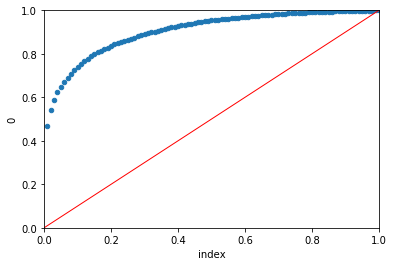

In [347]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[10::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

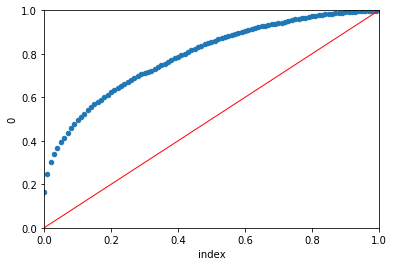

In [237]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[9::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

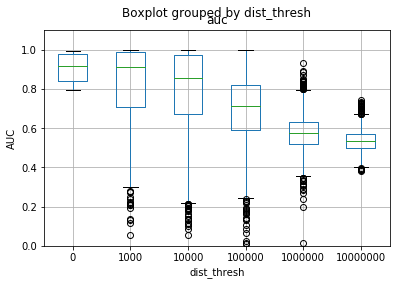

In [167]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='dist_thresh', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

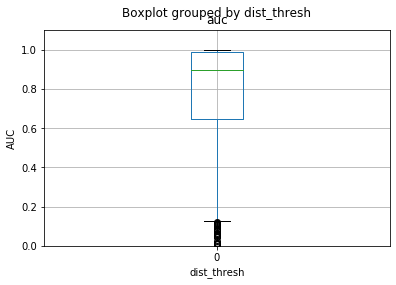

In [238]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='dist_thresh', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

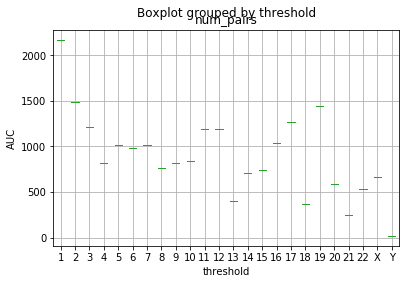

In [39]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['num_pairs'], by='threshold', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
#axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()